# Image Classification with Multi-layer Neural Network

> ### Artificial Intelligence - CA5
> ### Shakiba Bolbolian Khah - 810196426

In [32]:
import torchvision
import torch
import operator
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import timedelta
from sklearn.model_selection import train_test_split
from datetime import datetime

* **Connecting to Google drive in order to obtain data**

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* **Unzipping data for reading**

In [34]:
!unzip -q ./drive/My\ Drive/categorized_products.zip

replace categorized_products/Accessory Gift Set/19929.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [35]:
class CustomToTensor(object):
  ## the input image must be grayscaled first
  def __call__(self, image):
    image = np.array(image, dtype=np.float32)
    # numpy image: H x W
    return torch.from_numpy(image)

In [36]:
transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()])
dataset = ImageFolder( './categorized_products', transform=transform)

In [37]:
classes = dataset.classes

Method getClassIndices is defined to obtain corresponding indices for each image in dataframe. classPerIndex object eventually will have indices for each image seperated by class as a dictionary.

In [38]:
def getClassIndices():
  loader = DataLoader(dataset)
  classPerIndex = {classes[i] : [] for i in range(len(classes))}
  index = 0
  for _, labels in loader:
    for label in labels:
      classPerIndex[classes[label]] += [index]
    index += 1
  return classPerIndex

classPerIndex = getClassIndices()

Using classPerIndex object, population of each class can be caluculated easily.

In [39]:
def getNumberDistribution():
  totalCategoryCount = {classes[i] : 0 for i in range(len(classes))}
  for key in classPerIndex:
    totalCategoryCount[key] = len(classPerIndex[key])
  return totalCategoryCount

totalCategoryCount = getNumberDistribution()

In [40]:
def imshow(imgArray, labels, classes):
  _, axs = plt.subplots(3, 4) 
  for i in range(3):
    for j in range(4):
      axs[i][j].imshow(imgArray[i * 4 + j], cmap='gray')
      axs[i][j].set_title(classes[labels[i * 4 + j]])
      axs[i][j].axis('off')
  plt.show()

# Part 1

> By using classPerIndex, 12 image from 12 arbitrary classes can b selected. After that, it is just enough to iterate on data loader of images and show them with imshow function.

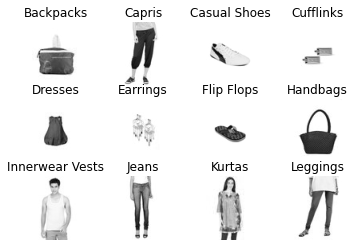

In [41]:
def part1():
  num = 0
  pics = []
  global classPerIndex
  for key in classPerIndex:
    if num == 24:
      break
    if num%2 == 1:
      pics.append(dataset[classPerIndex[key][10]])
    num += 1
  picLoader = DataLoader(pics, batch_size=12)
  dataIter = iter(picLoader)
  images, labels = dataIter.next()
  imshow(images[0:12], labels[0:12], classes)

part1()

# Part 2

> ### section I:
>> In order to have functional code, a function will be defined to plot bar chart for distribution of classes in part 2.

In [42]:
def plotOneBarChart(data, columns, yLabel, xLabel, titleMsg):
  fig = plt.figure(figsize=(20, 3))
  plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
  plt.bar(columns, data,align='edge', width=0.3)
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  plt.title(titleMsg)
  plt.show()

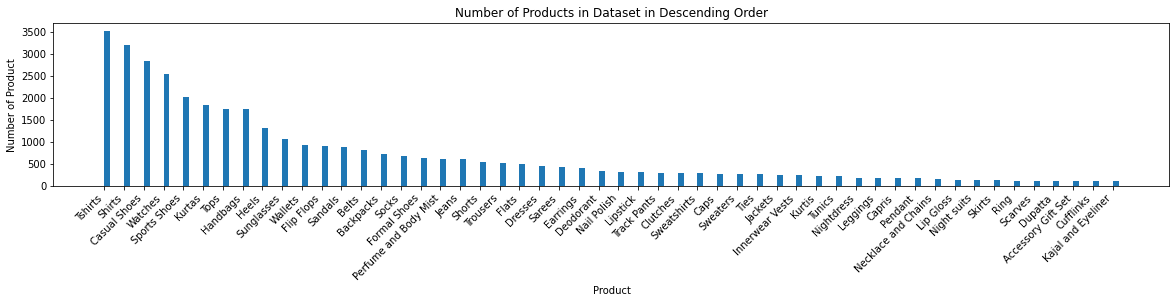

In [43]:
sortedCount = dict(sorted(totalCategoryCount.items(), key=operator.itemgetter(1),reverse=True))
plotOneBarChart(sortedCount.values(),sortedCount.keys(), 
    "Number of Product", "Product", "Number of Products in Dataset in Descending Order")

>> It seems that Tshirts class have way more samples in dataset compared to other classes. On the other hand Kajal and Eyeliner has the least number of data in dataset.
> ### section II:
>> In order to split dataset into train and test, firstly train_test_split can be helpful to split every dataset classes. Secondly sebsetRandomSampler creates sampler from selected indices. Finally creating dataloader object will let us work with test and train data.

In [44]:
batchSize = 64
targets = dataset.targets
trainIndices, testIndices = train_test_split(np.arange(len(targets)), test_size= 0.2, random_state=42, shuffle=True, stratify=targets)

trainSampler = SubsetRandomSampler(trainIndices)
testSampler = SubsetRandomSampler(testIndices)

trainLoader = DataLoader(dataset, batch_size=batchSize, sampler=trainSampler, num_workers=16)
testLoader = DataLoader(dataset, batch_size=batchSize, sampler=testSampler, num_workers=16)

# Part 3

> To implement network for dataset, layer 1 should have inputs as equal as number of pixels in each image whose size is 80*60 in this dataset. As well as this layer 5 ouputs number should be equals to number of classes which is 52 in this dataset. Other layers should just follow this rule that number of inputs in each layer should be equal to previous layer's number of outputs.

In [45]:
class Model(nn.Module):
  def __init__(self, classNum, act=F.relu):
    super(Model, self).__init__()

    self.layer1 = nn.Linear(60 * 80 , 8000)
    self.act1 = act

    self.layer2 = nn.Linear(8000, 6000)
    self.act2 = act

    self.layer3 = nn.Linear(6000, 3500)
    self.act3 = act

    self.layer4 = nn.Linear(3500, 500)
    self.act4 = act

    self.layer5 = nn.Linear(500, classNum)

  def forward(self, x):
    x = x.view(x.size(0), -1)

    x = self.layer1(x)
    x = self.act1(x)

    x = self.layer2(x)
    x = self.act2(x)

    x = self.layer3(x)
    x = self.act3(x)

    x = self.layer4(x)
    x = self.act4(x)

    x = self.layer5(x)
    return x

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
print(device)

cuda:0


In [48]:
def fit(model, trainLoader, device, criterion, optimizer, numEpochs=10):
  totalTime = 0.
  lossList = []
  for epoch in range(numEpochs):
    trainLoss = 0.
    d1 = datetime.now()
    for images, labels in trainLoader:
        
      images = images.to(device)
      labels = labels.to(device)

      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()

      # Forward pass to get output/logits
      outputs = model(images)

      # Calculate Loss: softmax --> cross entropy loss
      loss = criterion(outputs, labels)

      # Getting gradients w.r.t. parameters
      loss.backward()

      # Updating parameters
      optimizer.step()
      trainLoss += loss.item()

    averageLoss = trainLoss / len(trainLoader)
    lossList.append(averageLoss)
    d2 = datetime.now()
    delta = d2 - d1
    seconds = float(delta.total_seconds())
    totalTime += seconds
    print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, averageLoss, seconds))
  print('total training time: %.3f minutes' % (totalTime / 60))
  return lossList

> As we need to calculate recall for each class as well as accuracy for total dataset, modelRecall function has been defined. Not only this function calculates total accuracy, but also can calculate recall for each class by calculating number of correct predicted pictures per class.

In [49]:
def modelRecall(model, loader, testOrTrain):        
  correct = 0.
  total = 0.
  count = {classes[i] : [0,0] for i in range(len(classes))}
  recall = {classes[i] : 0. for i in range(len(classes))}
  with torch.no_grad():
    for images, labels in loader:
      outputs = model(images.to(device))
      _, predicted = torch.max(outputs.data, 1)
      for i in range(len(labels)):
        count[classes[labels[i]]][1] += 1
        if(labels[i] == predicted[i].to('cpu')):
          count[classes[labels[i]]][0] += 1
      total += labels.size(0)
      correct += (predicted.to('cpu') == labels).sum().item()
  accuracy = 100 * correct / total
  print('Accuracy for '+testOrTrain + ' data: ' + str(accuracy) + '%')
  
  for c in count:
    recall[c] = 100 * count[c][0]/count[c][1]
  return recall

> As well as plotOneBarChart model, this function has been defined to draw chart for recall per test and train dataset for each class.

In [50]:
def plotTwoBarChart(data1, data2, label1, label2, columns, yLabel, xLabel, titleMsg):
  fig = plt.figure(figsize=(20, 3))
  X = np.arange(len(columns))
  plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
  plt.bar(X - 0.2 , data1,align='edge', width=0.3, label = label1)
  plt.bar(X + 0.2 , data2,align='edge', width=0.3, label = label2)
  plt.xticks(X, columns)
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  plt.title(titleMsg)
  plt.legend()
  plt.show()

> This function is used to draw line chart for train loss in each epoch during model training.

In [51]:
def plotLineChart(x, y, xlabel, ylabel, title):
  plt.plot(x, y) 
  plt.xlabel(xlabel) 
  plt.ylabel(ylabel) 
  plt.title(title) 
  plt.show() 

In [52]:
def initWeights(model):
  if type(model) == nn.modules.linear.Linear:
    model.weight.data.fill_(0)
    model.bias.data.fill_(0)

> To keep functionality of code trainTestModel has been defined to train model, test it, calculate accuracy and recall, and plot desired chart for each one. It also can handle applying different paramters which are used if it is needed for any part.

In [53]:
def trainTestModel(learningRate, trainLoader, testLoader, note, needInit = 0, momentum_ = -1, numOfEpoch = 10, actFunc = F.relu, weightDecay = 0):
  model = Model(len(classes), actFunc)
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()

  if momentum_ != -1 and weightDecay != 0:
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum = momentum_, weight_decay=weightDecay) 
  elif momentum_ != -1:
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum = momentum_)
  elif weightDecay != 0:
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    
  if needInit:
    model = model.apply(initWeights)
  averageLoss = fit(model, trainLoader, device, criterion, optimizer, numOfEpoch)

  if not(np.isnan(averageLoss).any()):
    plotLineChart(range(1,numOfEpoch+1), averageLoss, "Num of Epoch", "Average Loss", "Average Loss per Epoch "+ note)
  testRecall = modelRecall(model, testLoader, "test")
  trainRecall = modelRecall(model, trainLoader, "train")
  plotTwoBarChart(trainRecall.values(), testRecall.values(), "Train", "Test", trainRecall.keys(), "Recall" , "Product", "Recall per Test & Train for Each Class"+ note )

> ### section I:
> 
>> **Bias:** Below came number of weight and bias parameters in each layer. It is easy to understand that number of bias parameters in each layer is equals to number of neurons in it. The reason is that each neuron has a bias and every layer has neuron number equals to number of output arguments in its layer. As a result layer1 will have 8000 bias parameters, layer2 6000, layer3 3500, layer4 500, and at last layer5 has 52 bias paramters which is equal to number of classes in dataset.
>>
>> **Wights:** In contrast to bias, which each neuron just has one, it is necessary that each neuron has one wight parameter per each input it has. As a result if there are n inputs for an arbitrary layer which contains m neurons, it will have $n\times m$ weight parameters. For instance in layer1 of this model, there are 4800 inputs and it contains 8000 neurons, so it will have $8000\times 4800 = 38400000$ weight parameters.

In [23]:
model = Model(len(classes))
model = model.to(device)
totalParams = 0
for name, param in model.named_parameters():
  if param.requires_grad:
      print (name, "\t\t", param.numel())
      totalParams += param.numel()
print("\nTotal Parameters in Model:", totalParams)

layer1.weight 		 38400000
layer1.bias 		 8000
layer2.weight 		 48000000
layer2.bias 		 6000
layer3.weight 		 21000000
layer3.bias 		 3500
layer4.weight 		 1750000
layer4.bias 		 500
layer5.weight 		 26000
layer5.bias 		 52

Total Parameters in Model: 109194052


> ### section II:

epoch 1, train_loss: nan, time elapsed: 14.899497 seconds
epoch 2, train_loss: nan, time elapsed: 14.864509 seconds
epoch 3, train_loss: nan, time elapsed: 14.761475 seconds
epoch 4, train_loss: nan, time elapsed: 14.823681 seconds
epoch 5, train_loss: nan, time elapsed: 14.824325 seconds
epoch 6, train_loss: nan, time elapsed: 14.981385 seconds
epoch 7, train_loss: nan, time elapsed: 14.884141 seconds
epoch 8, train_loss: nan, time elapsed: 14.825361 seconds
epoch 9, train_loss: nan, time elapsed: 14.894487 seconds
epoch 10, train_loss: nan, time elapsed: 14.888311 seconds
total training time: 2.477 minutes
Accuracy for test data: 0.2953020134228188%
Accuracy for train data: 0.29866774052820566%


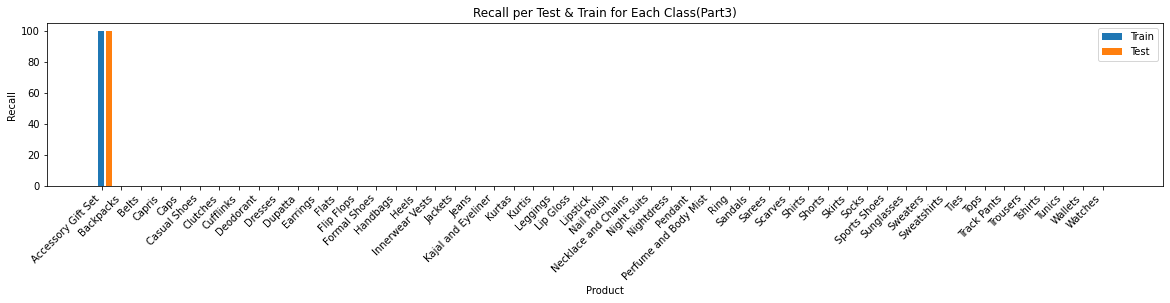

In [26]:
learningRate = 0.01
trainTestModel(learningRate, trainLoader, testLoader, "(Part3)")

> As it can be realized easily, train_loss equals to nan in each epoch and accuracy is even less than 1%. As well as this, it seems that model returns one class output for any given input. But why this happens?
>> According to description of part3, no data normalization has been applied on data and ever pixel's value is between 0 and 255. So weight parameters will be as large as inputs. The larger weight parameters get, the larger train_loss model faces. This continues untill it get bigger than max float value in python so it becomes to nan value. Eventually model is not trained well and train_loss reaches nan value.

# Part 4

> In order to normalize data, it is necessary to reload dataset with ToTensor transformer of pytorch which scales data as well as converting to tensor.

In [54]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
dataset = ImageFolder( './categorized_products', transform=transform)
normalTrainLoader = DataLoader(dataset, batch_size=batchSize, sampler=trainSampler, num_workers=16)
normalTestLoader = DataLoader(dataset, batch_size=batchSize, sampler=testSampler, num_workers=16)

epoch 1, train_loss: 3.408, time elapsed: 15.407073 seconds
epoch 2, train_loss: 2.715, time elapsed: 15.411849 seconds
epoch 3, train_loss: 2.254, time elapsed: 15.431899 seconds
epoch 4, train_loss: 1.924, time elapsed: 15.391482 seconds
epoch 5, train_loss: 1.741, time elapsed: 15.429811 seconds
epoch 6, train_loss: 1.612, time elapsed: 15.326367 seconds
epoch 7, train_loss: 1.518, time elapsed: 15.285505 seconds
epoch 8, train_loss: 1.440, time elapsed: 15.231734 seconds
epoch 9, train_loss: 1.377, time elapsed: 15.239734 seconds
epoch 10, train_loss: 1.325, time elapsed: 15.185063 seconds
total training time: 2.556 minutes


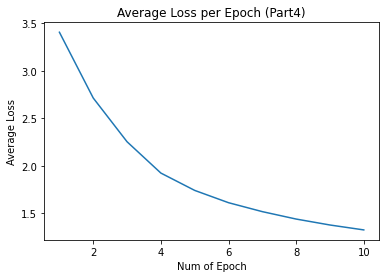

Accuracy for test data: 57.31543624161074%
Accuracy for train data: 57.62945065270647%


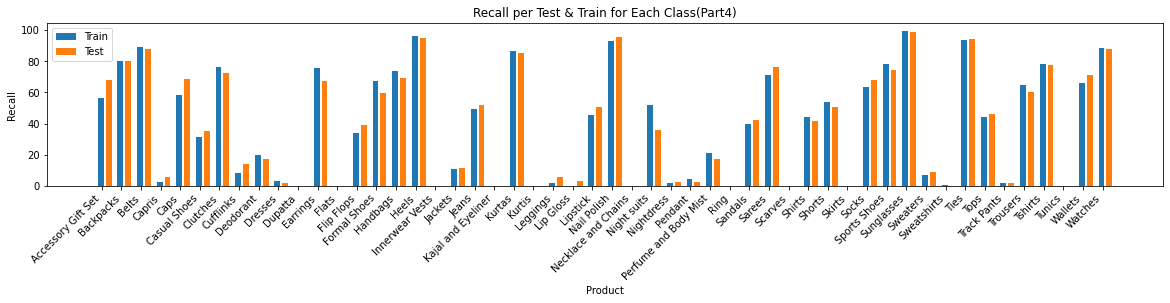

In [28]:
learningRate = 0.01
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part4)")

> In contrast with previous part, it seems accuracy has improved and train_loss has decreased significantly. this has happened because of data normalization. After normalization we had no more large values, so weight parameters have not increased a lot. Consequently model can be trained way better and accuracy improves.

# Part 5

> ### section I :

epoch 1, train_loss: 3.896, time elapsed: 15.051229 seconds
epoch 2, train_loss: 3.798, time elapsed: 15.094074 seconds
epoch 3, train_loss: 3.720, time elapsed: 15.06207 seconds
epoch 4, train_loss: 3.661, time elapsed: 14.996024 seconds
epoch 5, train_loss: 3.616, time elapsed: 15.154502 seconds
epoch 6, train_loss: 3.582, time elapsed: 15.111696 seconds
epoch 7, train_loss: 3.557, time elapsed: 15.287252 seconds
epoch 8, train_loss: 3.538, time elapsed: 15.14366 seconds
epoch 9, train_loss: 3.524, time elapsed: 15.220708 seconds
epoch 10, train_loss: 3.513, time elapsed: 15.358829 seconds
total training time: 2.525 minutes


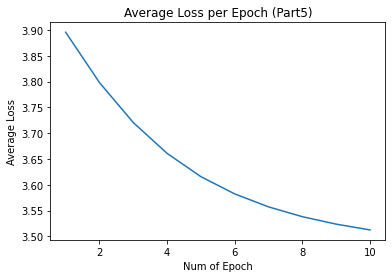

Accuracy for test data: 9.48993288590604%
Accuracy for train data: 9.48689553340716%


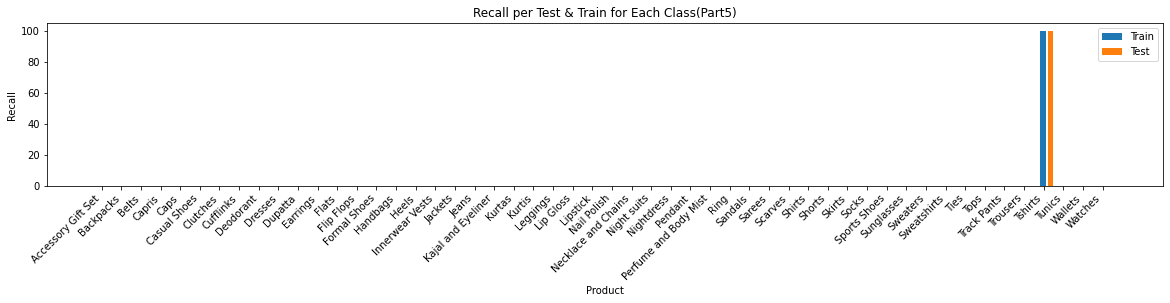

In [29]:
learningRate = 0.01
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part5)", needInit = 1)

>> After initiating all data to zero, model returns class with most population as an output for any given classes which is Tshirt. So accuracy has been decreased and train_loss has not changed very much. Why this happens?
>>> By initiating each weight and bias parametes to 0, ouputs of each neuron will be zero. As we know, by applying back propagation function, loss gradient value will multiply by neurons' ouput too. So for any neurons in hidden layers no update function will be applied. So all of our nodes will end up with the same value and it will be no different that having just one node in the hidden layer. Because of this, our network will end up learning just one function while the goal of a neural network is to have different nodes compute different functions. This is called the ‘Symmetry problem.’ In order to break this symmetry, we initialize the weights randomly.
>
> ### section II :
>> Actually it depends on different factors especially activation function. There are different methods of random initializing weights and bias parameters . We talk about two initialization techniques except random normal distribution which are more popular these days.
>>> * **Xavier Initialization:** This approach sets a layer’s weights to values chosen from a random uniform distribution that’s bounded between
$\frac{\pm \sqrt{6}}{\sqrt{{n}_i + {n}_{i+1}}}$ 
>>>> However this method will converge sooner. Conceptually, while using activation functions that are symmetric about zero such as tanh, we want the activation outputs of each layer to have a mean of 0 and a standard deviation around 1, on average. This is what Xavier enables, however in this case our activation function is relu which is not similar to tanh.
>>>
>>> * **Kaiming Initialization:** This approach contains three main steps which leads to convergance even in high number of layers. As a result in a world which relu function is used alot, Kaiming initialization can be the right choice.

# Part 6

> ### section I :
>> As it was said in different sources, it is better to try different learning rate value in exponential order while we try to find optimal rate using trial and error. To do this, different rates such as 1, 0.1, 0.001, 0.0001 has been tested in this part. Rate 0.01 has been applied before.

epoch 1, train_loss: nan, time elapsed: 15.341738 seconds
epoch 2, train_loss: nan, time elapsed: 15.401689 seconds
epoch 3, train_loss: nan, time elapsed: 15.30729 seconds
epoch 4, train_loss: nan, time elapsed: 15.272163 seconds
epoch 5, train_loss: nan, time elapsed: 15.194507 seconds
epoch 6, train_loss: nan, time elapsed: 15.300712 seconds
epoch 7, train_loss: nan, time elapsed: 15.143884 seconds
epoch 8, train_loss: nan, time elapsed: 15.156513 seconds
epoch 9, train_loss: nan, time elapsed: 15.114232 seconds
epoch 10, train_loss: nan, time elapsed: 14.989615 seconds
total training time: 2.537 minutes
Accuracy for test data: 0.2953020134228188%
Accuracy for train data: 0.29866774052820566%


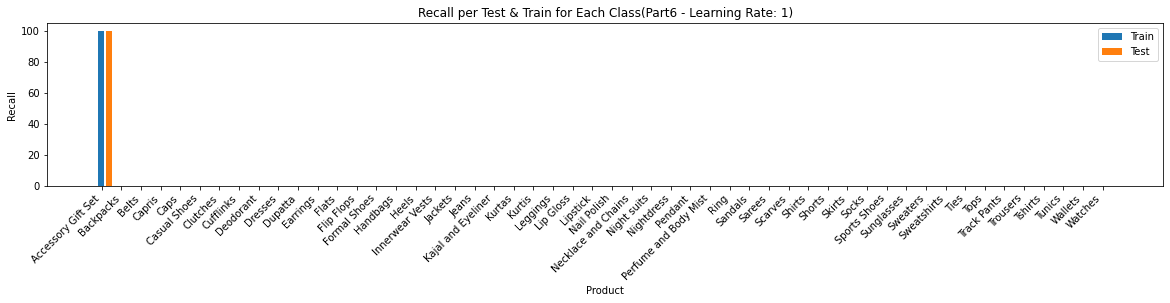

In [30]:
learningRate = 1
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part6 - Learning Rate: 1)")

epoch 1, train_loss: 3.086, time elapsed: 15.043798 seconds
epoch 2, train_loss: 2.216, time elapsed: 15.094226 seconds
epoch 3, train_loss: 1.842, time elapsed: 15.073425 seconds
epoch 4, train_loss: 1.582, time elapsed: 15.104224 seconds
epoch 5, train_loss: 1.443, time elapsed: 15.062111 seconds
epoch 6, train_loss: 1.308, time elapsed: 15.10145 seconds
epoch 7, train_loss: 1.239, time elapsed: 15.22846 seconds
epoch 8, train_loss: 1.186, time elapsed: 15.215965 seconds
epoch 9, train_loss: 1.102, time elapsed: 15.078224 seconds
epoch 10, train_loss: 1.056, time elapsed: 15.227613 seconds
total training time: 2.520 minutes


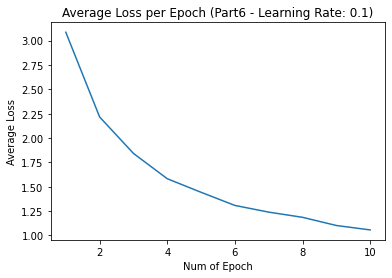

Accuracy for test data: 60.33557046979866%
Accuracy for train data: 61.26380079868452%


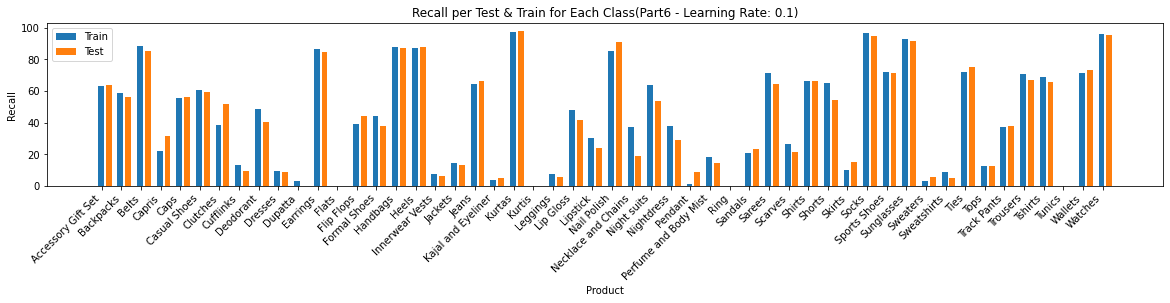

In [31]:
learningRate = 0.1
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part6 - Learning Rate: 0.1)")

epoch 1, train_loss: 3.880, time elapsed: 16.075302 seconds
epoch 2, train_loss: 3.603, time elapsed: 15.137526 seconds
epoch 3, train_loss: 3.454, time elapsed: 15.140231 seconds
epoch 4, train_loss: 3.428, time elapsed: 15.169405 seconds
epoch 5, train_loss: 3.402, time elapsed: 15.059865 seconds
epoch 6, train_loss: 3.362, time elapsed: 15.021693 seconds
epoch 7, train_loss: 3.290, time elapsed: 15.211722 seconds
epoch 8, train_loss: 3.172, time elapsed: 15.256588 seconds
epoch 9, train_loss: 3.038, time elapsed: 15.065699 seconds
epoch 10, train_loss: 2.927, time elapsed: 15.05151 seconds
total training time: 2.536 minutes


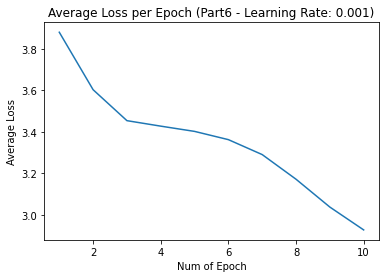

Accuracy for test data: 22.161073825503355%
Accuracy for train data: 22.252424578005975%


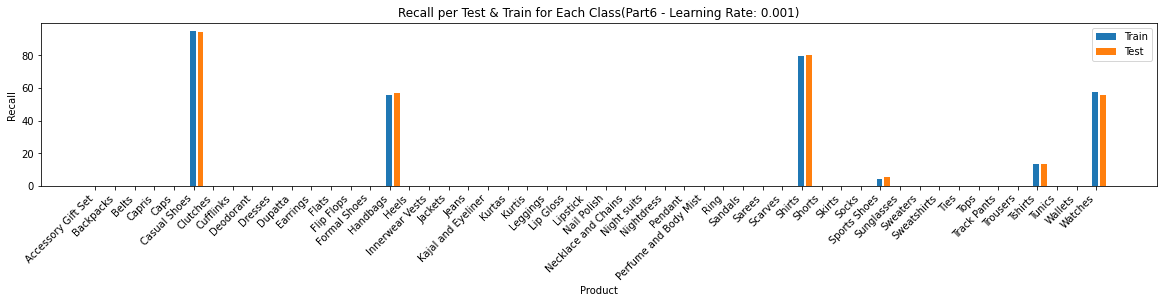

In [32]:
learningRate = 0.001
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part6 - Learning Rate: 0.001)")

epoch 1, train_loss: 3.941, time elapsed: 15.245335 seconds
epoch 2, train_loss: 3.927, time elapsed: 15.180561 seconds
epoch 3, train_loss: 3.915, time elapsed: 15.079893 seconds
epoch 4, train_loss: 3.902, time elapsed: 15.135709 seconds
epoch 5, train_loss: 3.889, time elapsed: 15.146444 seconds
epoch 6, train_loss: 3.873, time elapsed: 15.034907 seconds
epoch 7, train_loss: 3.856, time elapsed: 15.048546 seconds
epoch 8, train_loss: 3.836, time elapsed: 14.96391 seconds
epoch 9, train_loss: 3.811, time elapsed: 14.992361 seconds
epoch 10, train_loss: 3.782, time elapsed: 14.919513 seconds
total training time: 2.512 minutes


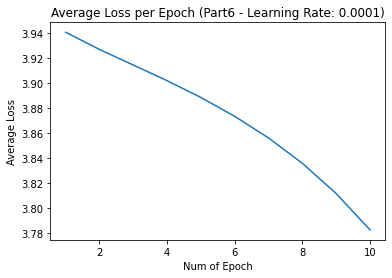

Accuracy for test data: 9.48993288590604%
Accuracy for train data: 9.48689553340716%


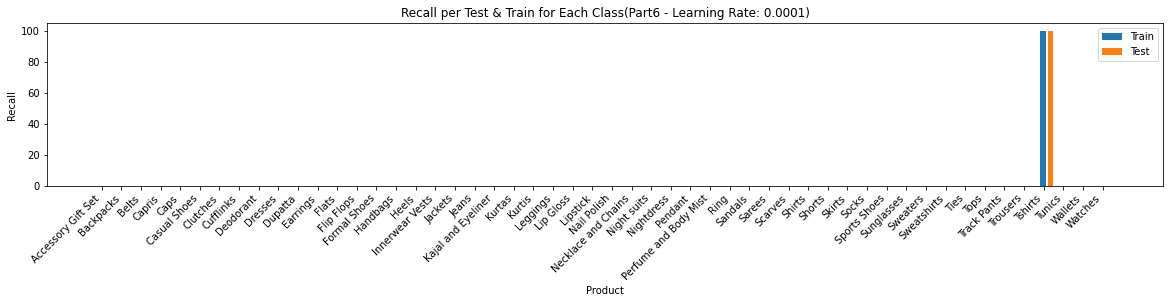

In [33]:
learningRate = 0.0001
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part6 - Learning Rate: 0.0001)")

epoch 1, train_loss: 2.814, time elapsed: 15.099482 seconds
epoch 2, train_loss: 2.008, time elapsed: 15.358673 seconds
epoch 3, train_loss: 1.683, time elapsed: 15.096502 seconds
epoch 4, train_loss: 1.459, time elapsed: 15.097544 seconds
epoch 5, train_loss: 1.353, time elapsed: 15.233577 seconds
epoch 6, train_loss: 1.257, time elapsed: 15.075263 seconds
epoch 7, train_loss: 1.184, time elapsed: 14.965929 seconds
epoch 8, train_loss: 1.117, time elapsed: 15.010741 seconds
epoch 9, train_loss: 1.072, time elapsed: 15.005484 seconds
epoch 10, train_loss: 1.026, time elapsed: 14.887124 seconds
total training time: 2.514 minutes


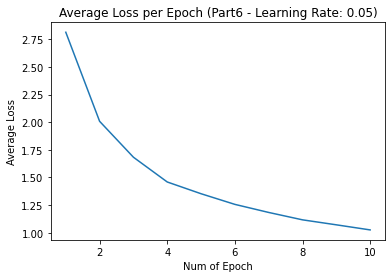

Accuracy for test data: 60.13422818791946%
Accuracy for train data: 61.35776368334508%


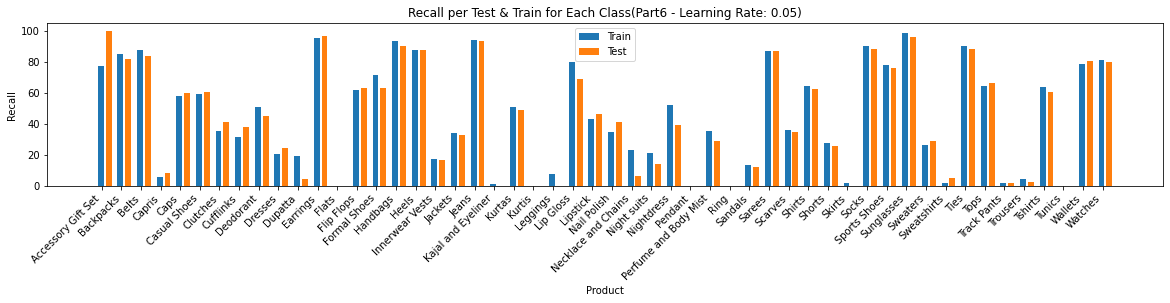

In [34]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part6 - Learning Rate: 0.05)")

>> It is obvious that with larger learning rate, decreasing amount of train_loss per epoch is more than smaller learning rate. Because by decreasing learning rate value, we actually prevent it from affecting model too much. So train_loss will change with little steps. More explanation came in next section. In this model, learning rate 0.1 and 0.01 had better accuracy and train_loss than others, so by trying another value in this range 0.05 has been selected as model's learning rate.
>>
> ### section II : 
>> The learning rate hyperparameter controls the rate or speed at which the model learns. It is also crucial that we choose the correct learning rate. Otherwise our network will either fail to train, or take much longer to converge.
>>
>> When the learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse. The model will learn faster than before but final weights may not be optimal and model can not be correct. 
>>
>> If the learning rate is low, it may allow the model to learn a more optimal or even globally optimal set of weights and training is more reliable but optimization will take a lot of time because steps towards the minimum of the loss function are tiny.
>>
>> In this section, learning rate 0.05 was selected as optimal one. To analyse other learning rate values, learning rate 0.1 and 0.01 act similarly to 0.05, since in a small range it has same behaviour. Totally in finding optimal learning rate value process, learning rates much higher than optimal value will decrease the accuracy. An this decreasing helps us find optimal value which leads to 0.05 in this model. 
Now we analyse learning rate values:
>>> **Learning rate = 1**: As said before when learning rate is very high, it will converge sooner but model will be way less optimal. In this case, train_loss was higher than float value and model has not been trained well at all. So accuracy is low too.
>>>
>>> **Learning rate = 0.1**: In comparison with value 0.05, in this case train_loss started from higher value and decreased with larger steps. Accuracy is similar to 0.05. However average recall per class seems better for learning value 0.05.
>>>
>>> **Learning rate = 0.01**: Its decreasing amount per epoch for train_loss is less than 0.05 and accuracy is similar. Less train_loss decreasing steps is because of less train rate.
>>>
>>> **Learning rate = 0.001**: Significantly train_loss decreasing steps has become smaller than preivious ones and because of that it has been remained in range (2.9,3.8) during 10 epochs. This also prevents model from being trained well and weight parameters did not reach optimal values. As a result just small numbers of classes can be recoginized by model and average recall per class is low.

# Part 7

> ### section I :
>> We first create new dataloader with batch size 32 and 128, then train model and test it with new train and test dataloader. 

In [25]:
batch32TrainLoader = DataLoader(dataset, batch_size= 32, sampler=trainSampler, num_workers=16)
batch32TestLoader = DataLoader(dataset, batch_size= 32, sampler=testSampler, num_workers=16)

epoch 1, train_loss: 2.533, time elapsed: 39.40692 seconds
epoch 2, train_loss: 1.721, time elapsed: 39.150338 seconds
epoch 3, train_loss: 1.448, time elapsed: 38.99986 seconds
epoch 4, train_loss: 1.299, time elapsed: 39.047338 seconds
epoch 5, train_loss: 1.189, time elapsed: 38.973688 seconds
epoch 6, train_loss: 1.106, time elapsed: 38.909785 seconds
epoch 7, train_loss: 1.045, time elapsed: 38.940615 seconds
epoch 8, train_loss: 0.993, time elapsed: 39.186107 seconds
epoch 9, train_loss: 0.950, time elapsed: 39.103403 seconds
epoch 10, train_loss: 0.906, time elapsed: 39.142544 seconds
total training time: 6.514 minutes


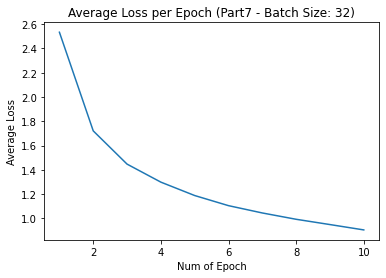

Accuracy for test data: 60.49664429530201%
Accuracy for train data: 61.314138058324104%


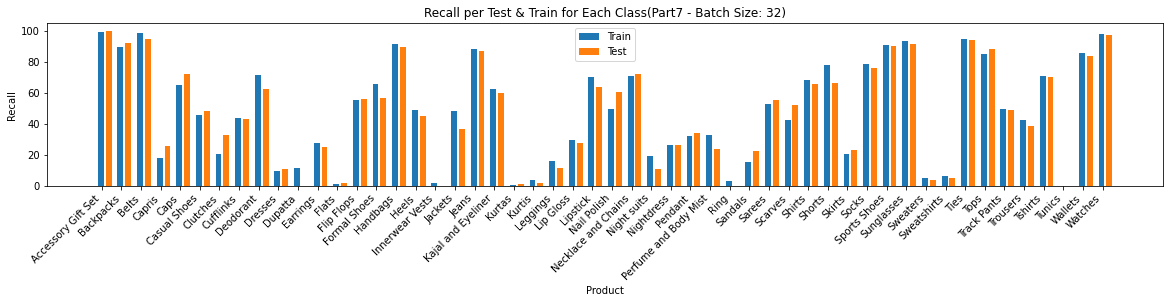

In [26]:
learningRate = 0.05
trainTestModel(learningRate, batch32TrainLoader, batch32TestLoader, "(Part7 - Batch Size: 32)")

In [55]:
batch128TrainLoader = DataLoader(dataset, batch_size= 128, sampler=trainSampler, num_workers=16)
batch128TestLoader = DataLoader(dataset, batch_size= 128, sampler=testSampler, num_workers=16)

epoch 1, train_loss: 3.150, time elapsed: 18.940713 seconds
epoch 2, train_loss: 2.382, time elapsed: 19.042048 seconds
epoch 3, train_loss: 2.044, time elapsed: 19.316863 seconds
epoch 4, train_loss: 1.800, time elapsed: 19.076238 seconds
epoch 5, train_loss: 1.639, time elapsed: 19.156433 seconds
epoch 6, train_loss: 1.513, time elapsed: 19.186004 seconds
epoch 7, train_loss: 1.410, time elapsed: 19.095344 seconds
epoch 8, train_loss: 1.329, time elapsed: 18.990208 seconds
epoch 9, train_loss: 1.260, time elapsed: 19.112122 seconds
epoch 10, train_loss: 1.218, time elapsed: 19.073203 seconds
total training time: 3.183 minutes


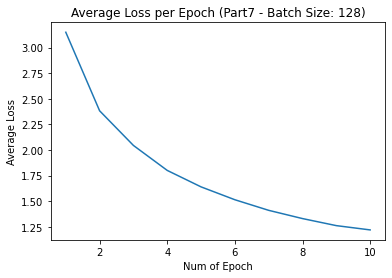

Accuracy for test data: 61.328859060402685%
Accuracy for train data: 62.414846135776365%


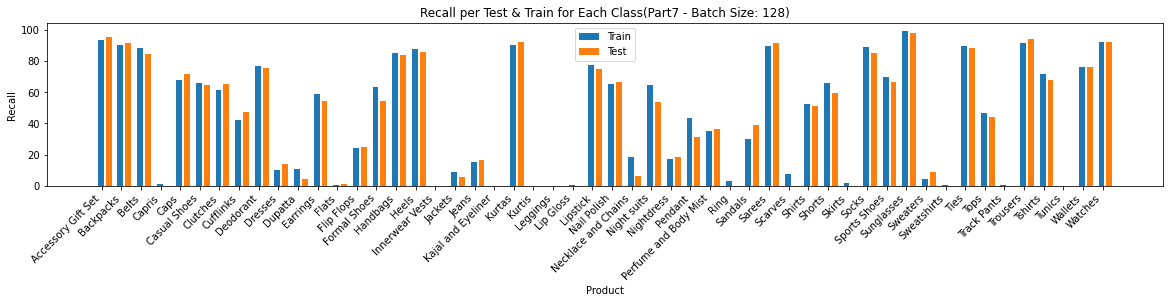

In [56]:
learningRate = 0.05
trainTestModel(learningRate, batch128TrainLoader, batch128TestLoader, "(Part7 - Batch Size: 128)")

> Generally batch size is the number of training examples used in the estimate of the error gradient. Now we discuss about different amounts of batch size and their effect on model training. As a result The batch size impacts how quickly a model learns and the stability of the learning process.
>> **Batch Size 32**: Generally it is obvious that it took longer for model to be trained(40 seconds per epoch). But train_loss decreases significantly, also accuracy remians the same. But average recall in some classes has changed. However batch size 32 is not very small that harms model training.
>>> **Pros and Cons of Smaller Batch Size**:
>>>
>>> * Smaller batch sizes make it easier to fit one batch while using less memory for training data. It is very helpful especially using GPU.
>>> * The downside of using a smaller batch size is that the model is not guaranteed to converge to the global optima.
>>> * Totally smaller batch sizes train slower, but can converge faster. 
The lower we go, the less accurate our esttimate will be, however in some cases these noisy gradients can actually help escape local minima. When it is too low, our network weights can just jump around if your data is noisy and it might be unable to learn or it converges very slowly, thus negatively impacting total computation time.
>>
>> **Batch Size 128**: In this case training completes faster(18 seconds per epoch) but average recall is less, so does the accuracy. Lets discuss its reasons in pros and cons part.
>>> **Pros and Cons of Smaller Batch Size**:
>>>
>>> * Too large batch size will lead to poor generalization.
>>> * Model will be trained faster because effects of each training epochs will be applied more.
>
> ### section II :
>> Hyperparameters mostly should change when batch size changes. According to learn how learning rate parameter should change whan batch size increases, we test one higher learning rate value (0.07) and a less one (0.01) and study their behaviour.

epoch 1, train_loss: 3.074, time elapsed: 19.001758 seconds
epoch 2, train_loss: 2.377, time elapsed: 19.164343 seconds
epoch 3, train_loss: 2.050, time elapsed: 19.082663 seconds
epoch 4, train_loss: 1.806, time elapsed: 19.073799 seconds
epoch 5, train_loss: 1.597, time elapsed: 18.997783 seconds
epoch 6, train_loss: 1.477, time elapsed: 19.117054 seconds
epoch 7, train_loss: 1.400, time elapsed: 19.017508 seconds
epoch 8, train_loss: 1.317, time elapsed: 19.15659 seconds
epoch 9, train_loss: 1.250, time elapsed: 19.134497 seconds
epoch 10, train_loss: 1.199, time elapsed: 19.123805 seconds
total training time: 3.181 minutes


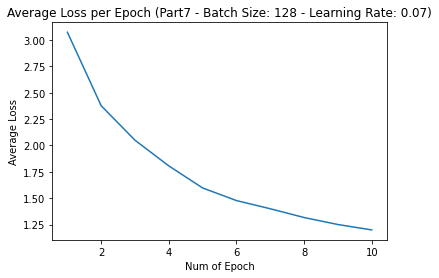

Accuracy for test data: 61.48993288590604%
Accuracy for train data: 62.17993892412497%


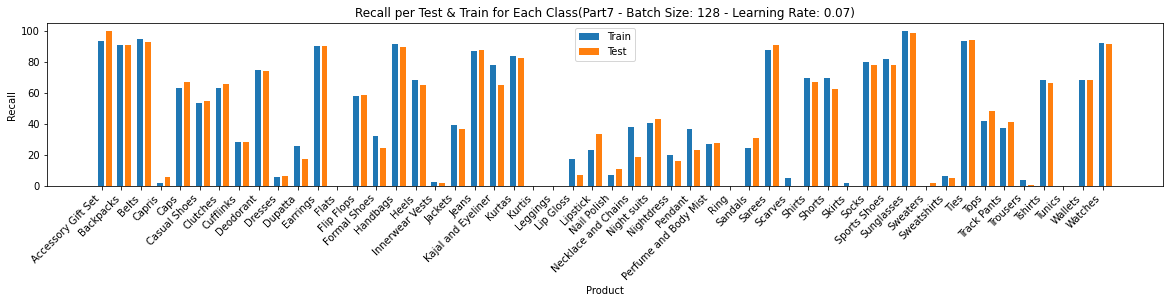

In [57]:
learningRate = 0.07
trainTestModel(learningRate, batch128TrainLoader, batch128TestLoader, "(Part7 - Batch Size: 128 - Learning Rate: 0.07)")

epoch 1, train_loss: 3.564, time elapsed: 11.923771 seconds
epoch 2, train_loss: 3.232, time elapsed: 12.220113 seconds
epoch 3, train_loss: 2.814, time elapsed: 11.942164 seconds
epoch 4, train_loss: 2.563, time elapsed: 11.931319 seconds
epoch 5, train_loss: 2.290, time elapsed: 12.185115 seconds
epoch 6, train_loss: 2.084, time elapsed: 12.064519 seconds
epoch 7, train_loss: 1.922, time elapsed: 12.01759 seconds
epoch 8, train_loss: 1.803, time elapsed: 12.03596 seconds
epoch 9, train_loss: 1.717, time elapsed: 11.974637 seconds
epoch 10, train_loss: 1.645, time elapsed: 11.923532 seconds
total training time: 2.004 minutes


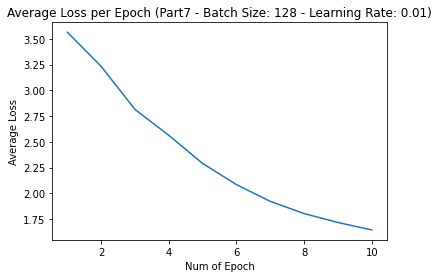

Accuracy for test data: 45.22147651006711%
Accuracy for train data: 45.58206651229907%


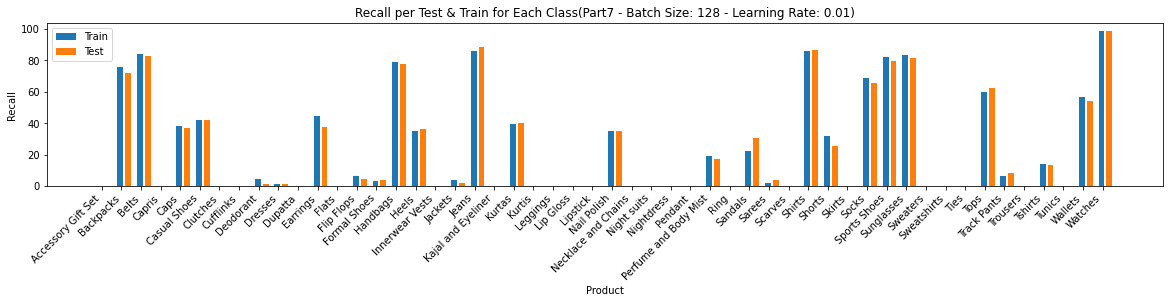

In [40]:
learningRate = 0.01
trainTestModel(learningRate, batch128TrainLoader, batch128TestLoader, "(Part7 - Batch Size: 128 - Learning Rate: 0.01)")

>> It seems that by decreasing learning rate while batch size has been increased, model will not be trained well enough, train_loss will remain larger till last epoch and total accuracy will decrease significantly. However larger learning rate helps model learn better and have more accuracy. Its train_loss will decrease till last epochs and model behavious is better totally. Let's discuss the reason.
>>>**General Rule! Bigger Batch Size,Bigger Learning Rate**:
>>> Totally theory suggests that when multiplying the batch size by k,the learning rate should be multiplied by sqrt(k) to keep the variance in the gradient expectation constant.
It s resonable because in each epoch we see more data  -cause batch size is bigger-. So larger portion of dataset will be trained in each epoch which finally leads to model. It is obvious that bigger part of population should have more significant effect on model than smaller part. In conclusion larger learning rate provides this larger effect. So the rule is completely reasonable as the result has proved it too.

# Part 8
> ### section I:
>> **What is momentum?**:
>>  Momentum is an added term in the objective function, which is a value between 0 and 1 that increases the size of the steps taken towards the minimum by trying to jump from a local minimum.
>> **Effects of Using Momentum**:
>>> **Pros**: Model with momentum almost always works better and faster than Stochastic Gradient Descent beacause of following reasons.
>>>
>>>> **1.** With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives may be noisy. However using momentum provides us a better estimate which is closer to the actual derivate.
>>>>
>>>> **2.** The second reason would be ravines. Ravines are common near local minimas in deep learning and SGD has troubles navigating them. SGD tends to oscillate across the narrow ravine, and in this situation momentum helps accelerate gradients in the right direction.
>>>
>>> **Cons**: Actually using momentum leads to complex model more than usual.
>
> ### section II:

epoch 1, train_loss: 2.511, time elapsed: 17.874974 seconds
epoch 2, train_loss: 1.790, time elapsed: 17.757989 seconds
epoch 3, train_loss: 1.474, time elapsed: 17.803494 seconds
epoch 4, train_loss: 1.310, time elapsed: 17.771813 seconds
epoch 5, train_loss: 1.199, time elapsed: 17.819926 seconds
epoch 6, train_loss: 1.108, time elapsed: 17.702823 seconds
epoch 7, train_loss: 1.046, time elapsed: 17.809436 seconds
epoch 8, train_loss: 0.996, time elapsed: 17.829936 seconds
epoch 9, train_loss: 0.966, time elapsed: 17.776236 seconds
epoch 10, train_loss: 0.921, time elapsed: 17.871775 seconds
total training time: 2.967 minutes


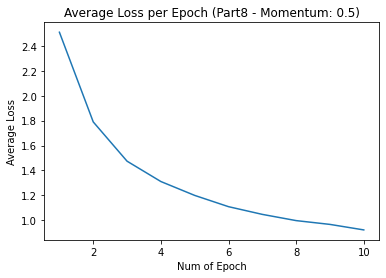

Accuracy for test data: 69.79865771812081%
Accuracy for train data: 71.8279136883788%


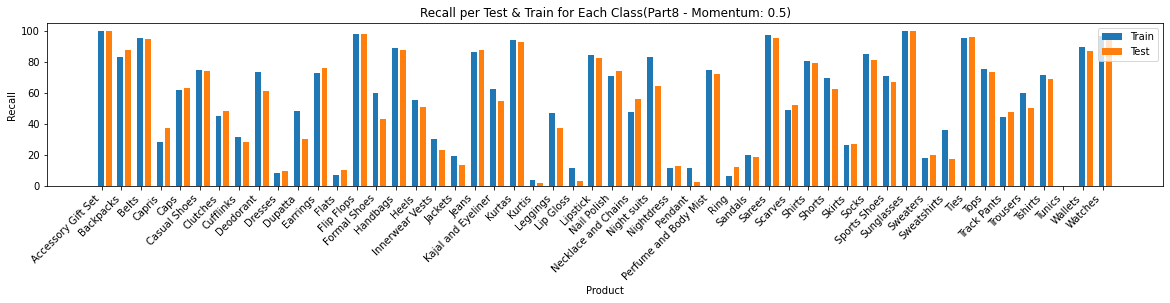

In [41]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part8 - Momentum: 0.5)", momentum_ = 0.5)

epoch 1, train_loss: 2.862, time elapsed: 17.864947 seconds
epoch 2, train_loss: 2.415, time elapsed: 17.857005 seconds
epoch 3, train_loss: 2.022, time elapsed: 17.959228 seconds
epoch 4, train_loss: 1.885, time elapsed: 17.8322 seconds
epoch 5, train_loss: 1.782, time elapsed: 17.792787 seconds
epoch 6, train_loss: 1.701, time elapsed: 17.854946 seconds
epoch 7, train_loss: 1.704, time elapsed: 17.792249 seconds
epoch 8, train_loss: 1.655, time elapsed: 17.858886 seconds
epoch 9, train_loss: 1.659, time elapsed: 17.819756 seconds
epoch 10, train_loss: 1.647, time elapsed: 17.893117 seconds
total training time: 2.975 minutes


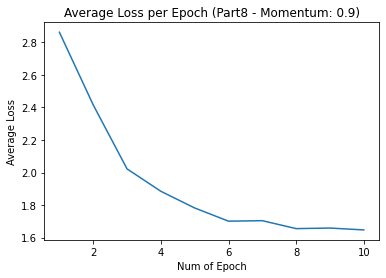

Accuracy for test data: 43.59731543624161%
Accuracy for train data: 44.23638377126749%


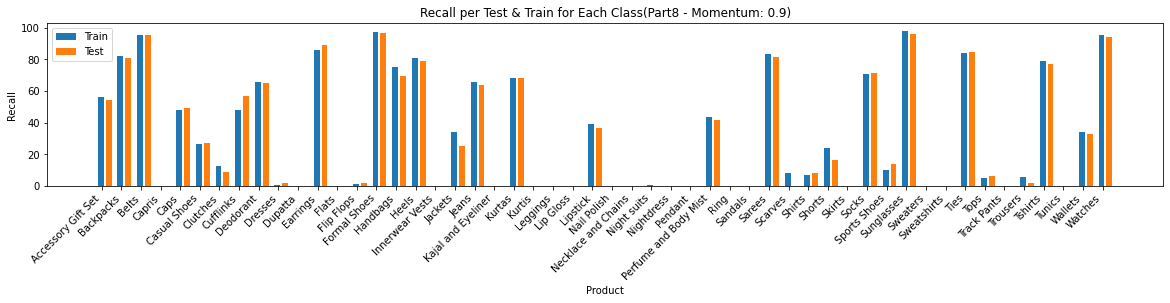

In [42]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part8 - Momentum: 0.9)", momentum_ = 0.9)

epoch 1, train_loss: nan, time elapsed: 17.957403 seconds
epoch 2, train_loss: nan, time elapsed: 17.787337 seconds
epoch 3, train_loss: nan, time elapsed: 17.799404 seconds
epoch 4, train_loss: nan, time elapsed: 17.817945 seconds
epoch 5, train_loss: nan, time elapsed: 17.866478 seconds
epoch 6, train_loss: nan, time elapsed: 17.974057 seconds
epoch 7, train_loss: nan, time elapsed: 17.916842 seconds
epoch 8, train_loss: nan, time elapsed: 17.795071 seconds
epoch 9, train_loss: nan, time elapsed: 17.941415 seconds
epoch 10, train_loss: nan, time elapsed: 17.965069 seconds
total training time: 2.980 minutes
Accuracy for test data: 0.2953020134228188%
Accuracy for train data: 0.29866774052820566%


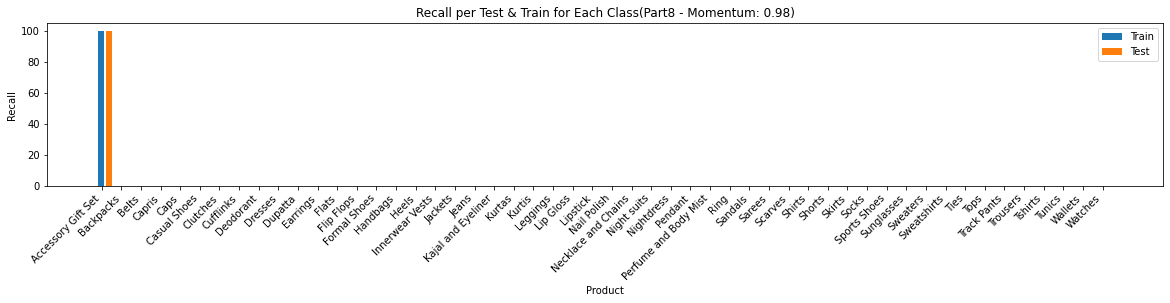

In [43]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part8 - Momentum: 0.98)", momentum_= 0.98)

>> Momentum value can not be niether too large nor too small. As it can be noticed in this section, for momentum value 0.5, model has improved, accuracy and average recall per classes increased and train_loss decreased. This is all because of the reasons said in section 1. However for momentum value 0.9 and 0.98, accuracy and recall has decreased significantly and train_loss increased in order that it reached value more than float capacity in python and became nan.
>>
>> But Why this happened? (explanation in section III)
>
> ### section III: 
> A large value of momentum also means that the convergence will happen fast. But if both the momentum and learning rate are kept at large values, then model might skip the minimum with a huge step. Because of that, using large momentum value like 0.9 and 0.98 without decreasing learning rate caused misbehaviour in section II. On the other hand a small value of momentum cannot reliably avoid local minima, and can also slow down the training of the system. 
In conclusion, defining optimal value for momentum depends on dataset and other hyperparameter. But it is a general rule that by using large momentum value, learning rate should be kept smaller.

# Part 9
> ### section I:
> Number of epochs has been updated to 20 and model has been trained and tested again.

epoch 1, train_loss: 2.576, time elapsed: 18.009095 seconds
epoch 2, train_loss: 1.783, time elapsed: 18.132527 seconds
epoch 3, train_loss: 1.477, time elapsed: 17.990991 seconds
epoch 4, train_loss: 1.370, time elapsed: 18.008176 seconds
epoch 5, train_loss: 1.235, time elapsed: 17.979517 seconds
epoch 6, train_loss: 1.162, time elapsed: 17.978624 seconds
epoch 7, train_loss: 1.079, time elapsed: 17.955366 seconds
epoch 8, train_loss: 1.027, time elapsed: 17.991575 seconds
epoch 9, train_loss: 0.972, time elapsed: 17.869019 seconds
epoch 10, train_loss: 0.935, time elapsed: 17.866143 seconds
epoch 11, train_loss: 0.890, time elapsed: 17.907877 seconds
epoch 12, train_loss: 0.868, time elapsed: 17.892736 seconds
epoch 13, train_loss: 0.835, time elapsed: 17.986714 seconds
epoch 14, train_loss: 0.811, time elapsed: 17.859407 seconds
epoch 15, train_loss: 0.787, time elapsed: 17.848463 seconds
epoch 16, train_loss: 0.762, time elapsed: 17.83086 seconds
epoch 17, train_loss: 0.742, time 

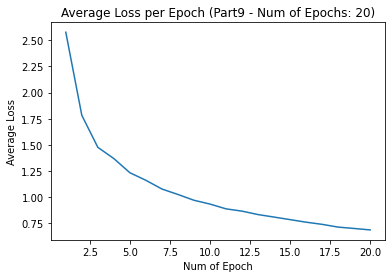

Accuracy for test data: 72.87248322147651%
Accuracy for train data: 75.84482700761771%


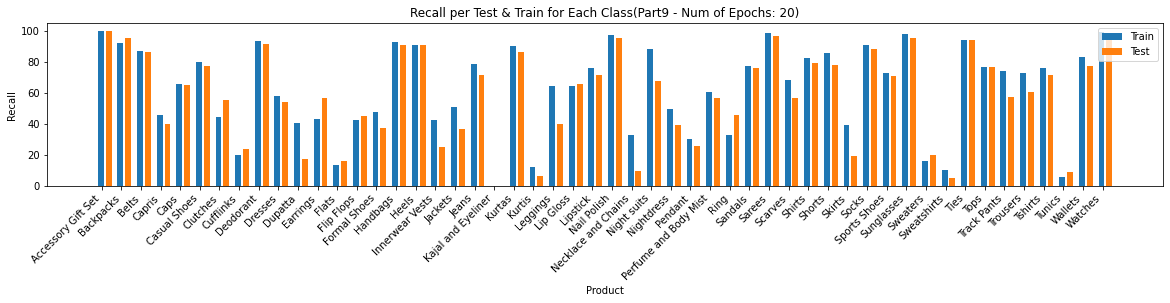

In [44]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part9 - Num of Epochs: 20)", numOfEpoch = 20, momentum_ = 0.5 )

>> It is predictable that it takes much longer for model to be trained with larger epoch number. Due to this train_loss has been decreased continuosly till last epoch and model is trained better which cause growth in model accuracy and average recall per class. So every aspects has improved with this increament. However it is notable that model has not been overfitted after increasing number of epochs. In some cases it might happen, then accuracy on train data increases but on test one will decrease significantly.
>
> ### section II:
>> In terms of artificial neural networks, an epoch refers to one cycle through the full training dataset. Usually, training a neural network takes more than a few epochs. Because if we feed a neural network the training data for one epoch, there may be some data which has not been studying at all. So the model will not be well-trained enough to work effectively on test and train dataset. But if we feed a neural network the training data for more than one epoch in different patterns, we hope for a better generalization when given a new unseen input (test data). Which leads to better result.
>
> ### section III:
>> Absoloutly not! Any data contains two part: behavior pattern and noise. The main goal is always to find the pattern using Deep Learning model. DL model tries ti minimum error or maximum accuracy. In the process of minimizing error, it would have learnt the pattern but the error would not reach a absolute zero. If the training is continued for more epochs, model tries to reach zero error where it is starting to learn the noise of training data. This noise can change from data sample to sample and learning them cause overfitting. As said before overfitting leads to high accuracy for train data and less accuracy in test one.

# Part 10
> ### tanh Activation Function:
>> The tanh function is defined as follows:
>> $$ tanh(x) = \frac{2}{1+ e^{-2x} } -1 $$
>> * It is nonlinear and bound to the range (-1, 1). 
>> * The gradient is stronger for tanh than sigmoid.
>> * Tanh has a vanishing gradient problem. This problem arises due to the nature of the backpropagation optimization. It results in a decrease in the prediction accuracy of the model and take a long time to train a model.
>>
>> However in this case we see no significant differences between relu and tanh operation. Both leads to near accuracy, because tanh is differentiable and limited in output, so it leads to good result. However it can cause vanishing problem(as said above) and is expensive to compute which depends on dataset and we did not face this problem here.

epoch 1, train_loss: 2.071, time elapsed: 17.880183 seconds
epoch 2, train_loss: 1.429, time elapsed: 17.897672 seconds
epoch 3, train_loss: 1.241, time elapsed: 18.128993 seconds
epoch 4, train_loss: 1.140, time elapsed: 17.682621 seconds
epoch 5, train_loss: 1.056, time elapsed: 17.734585 seconds
epoch 6, train_loss: 0.996, time elapsed: 17.738917 seconds
epoch 7, train_loss: 0.954, time elapsed: 17.761246 seconds
epoch 8, train_loss: 0.905, time elapsed: 17.798033 seconds
epoch 9, train_loss: 0.881, time elapsed: 17.885316 seconds
epoch 10, train_loss: 0.834, time elapsed: 17.752149 seconds
total training time: 2.971 minutes


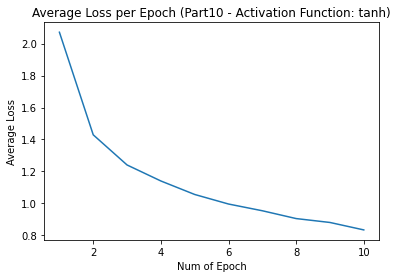

Accuracy for test data: 69.32885906040268%
Accuracy for train data: 71.13997113997114%


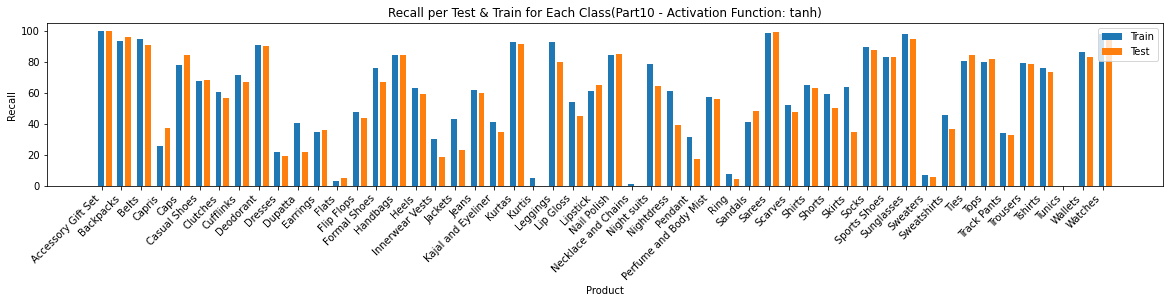

In [45]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part10 - Activ0ation Function: tanh)", actFunc = torch.tanh, momentum_ = 0.5)

> ### Leaky ReLU Activation Function:
>> This function attemps to fix "dying ReLU problem".
>>> *Dying ReLU Problem:* If once neuron gets negative it is unlikely for it to recover. This is called “dying ReLU” problem. If the learning rate is too high the weights may change to a value that causes the neuron to not get updated at any data point again.
>>>
>> In RLeaky ReLU, instead of the function return 0 when x < 0, it gives a small negative slope.
>> In this case, after applying leaky ReLU as activation function, accuracy and average recall per class has decreased. However t depends on network, dataset and even which each run, it may change. In my opinion, since all input values are between 0 and 1, and leaky ReLU consider little value for nagative input so it may affect the operation of model.

epoch 1, train_loss: 2.601, time elapsed: 17.649339 seconds
epoch 2, train_loss: 1.767, time elapsed: 17.80612 seconds
epoch 3, train_loss: 1.500, time elapsed: 17.917935 seconds
epoch 4, train_loss: 1.312, time elapsed: 17.742459 seconds
epoch 5, train_loss: 1.207, time elapsed: 17.782013 seconds
epoch 6, train_loss: 1.123, time elapsed: 17.860871 seconds
epoch 7, train_loss: 1.063, time elapsed: 17.845787 seconds
epoch 8, train_loss: 1.005, time elapsed: 17.786451 seconds
epoch 9, train_loss: 0.958, time elapsed: 17.825773 seconds
epoch 10, train_loss: 0.921, time elapsed: 17.869632 seconds
total training time: 2.968 minutes


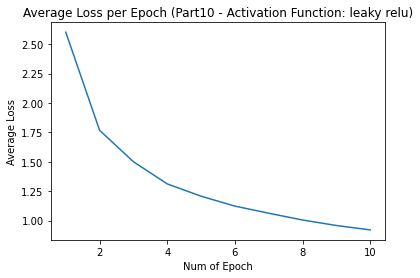

Accuracy for test data: 66.42953020134229%
Accuracy for train data: 67.88147253263533%


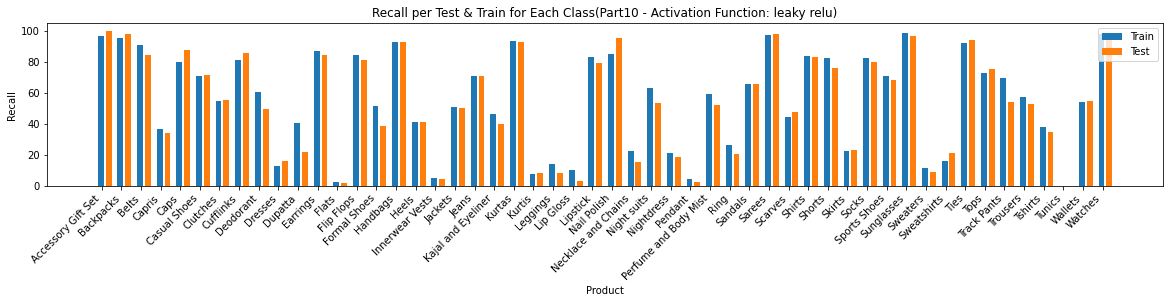

In [46]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part10 - Activation Function: leaky relu)", actFunc = F.leaky_relu, momentum_ = 0.5)

# Part 11
> ### section I:
>> As said before, an overfitted model performs well on training data but fails to generalize.Goal of our machine learning algorithm is to learn the data patterns and ignore the noise in the data set. We can solve the problem of overfitting using:
>> * Regularization technique
>> * Cross Validation
>> * Drop out
>>
>> In this part we provide the first method.
>>
>> **What is Regularization?**:
>>
>>> Regularization is a technique to decrease model's complexity. It does this by penalizing the loss function. This helps to solve the overfitting problem.
>>>
>>> Loss function is the sum of squared difference between the actual value and the predicted value. As the degree of the input features increases the model becomes complex and tries to fit all the data which leads to overfitting. So the solution is to simplify model by ignoring some terms in loss function.This is what regularization does! It works on assumption that smaller weights generate simpler model and thus helps avoid overfitting.
>>>
>>> One way to use regularization is to add the regularization term to the sum of squared differences between the actual value and predicted value. The term is loke below:
>>> $$ \lambda \sum\limits_{i=1}^n \theta_{i}^2 $$
>> As a result when $\lambda$ is zero the regularization term will be zero and original loss function will be available. As much as $\lambda$ get higher, the loss function gets closer to 0 so we have simpler method which prevents overfitting because weights remain in same range.
>>
>> **Note**: Totally there are 2 major method of regularization: L1 and L2. In L1 we works with absolute value of the weights, but L2 -as shown above- is sum of square of all feature weights. This method forces the weight to be small but does not make them zero.
>
> ### section II:
>>
>> Weight decay method Penalize the model during training based on the magnitude of the weights. This will encourage the model to map the inputs to the outputs of the training dataset in such a way that the weights of the model are kept small. 
>> According to L2 regularization term which was described in previous section, the weight_decay parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights. So it works like term in loss function and prevents overfitting.
>
> ### section III:
>> Model has been trained with weight_decay 0.1 and the result came below.

epoch 1, train_loss: 3.456, time elapsed: 19.633196 seconds
epoch 2, train_loss: 3.382, time elapsed: 19.691801 seconds
epoch 3, train_loss: 3.376, time elapsed: 19.592315 seconds
epoch 4, train_loss: 3.372, time elapsed: 19.775062 seconds
epoch 5, train_loss: 3.379, time elapsed: 19.627822 seconds
epoch 6, train_loss: 3.373, time elapsed: 19.69018 seconds
epoch 7, train_loss: 3.382, time elapsed: 19.738374 seconds
epoch 8, train_loss: 3.379, time elapsed: 19.58629 seconds
epoch 9, train_loss: 3.378, time elapsed: 19.719855 seconds
epoch 10, train_loss: 3.374, time elapsed: 19.702315 seconds
total training time: 3.279 minutes


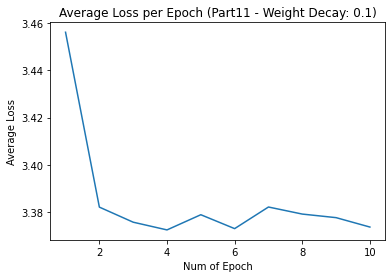

Accuracy for test data: 9.48993288590604%
Accuracy for train data: 9.483539716097855%


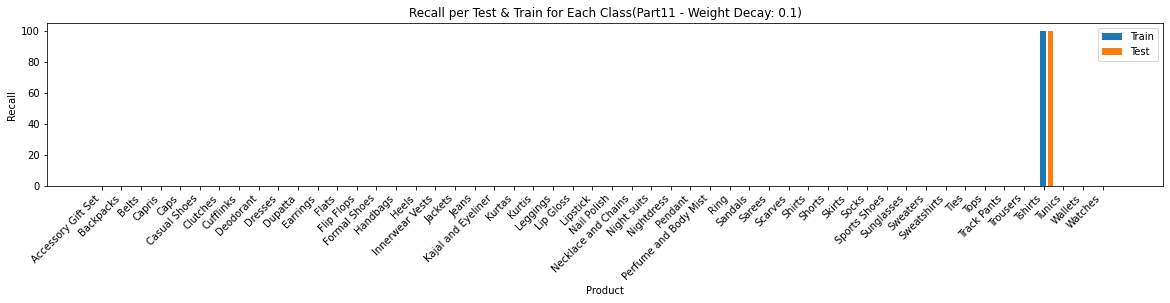

In [47]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part11 - Weight Decay: 0.1)", momentum_ = 0.5, weightDecay = 0.1)

>> As it was shown in charts, accuracy decreased significantly, train_loss did not decreased per epoch and model is trained in a way which returns the class with the most population for any input. It seems that the model became too simple to even work on train dataset.
>
> ### section IV:
>> We repeated previous part with weight_decay 0.01 and analyse output again.

epoch 1, train_loss: 2.647, time elapsed: 19.726369 seconds
epoch 2, train_loss: 2.054, time elapsed: 19.857472 seconds
epoch 3, train_loss: 1.870, time elapsed: 19.670395 seconds
epoch 4, train_loss: 1.858, time elapsed: 19.684981 seconds
epoch 5, train_loss: 1.797, time elapsed: 19.629587 seconds
epoch 6, train_loss: 1.854, time elapsed: 19.658197 seconds
epoch 7, train_loss: 1.890, time elapsed: 19.69936 seconds
epoch 8, train_loss: 1.743, time elapsed: 19.671404 seconds
epoch 9, train_loss: 1.793, time elapsed: 19.852413 seconds
epoch 10, train_loss: 1.796, time elapsed: 19.716788 seconds
total training time: 3.286 minutes


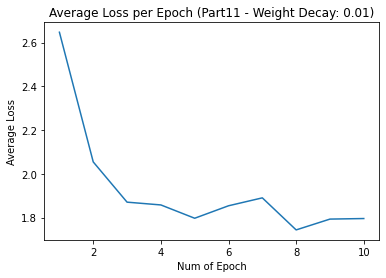

Accuracy for test data: 36.76510067114094%
Accuracy for train data: 36.957616027383466%


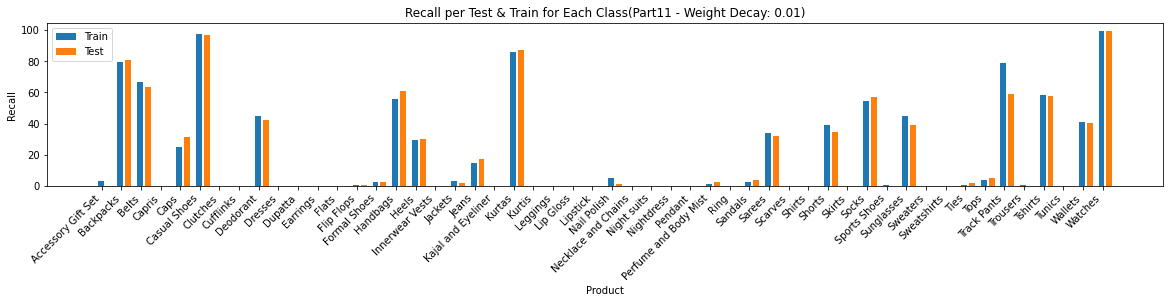

In [48]:
learningRate = 0.05
trainTestModel(learningRate, normalTrainLoader, normalTestLoader, "(Part11 - Weight Decay: 0.01)", momentum_ = 0.5, weightDecay = 0.01)

>> It seems that less wight_decay worked better than higher one. Train_loss has decreased during training more than previous section -however it had its rise and fall-. The model has been trained a little better which detects some classes at least. But totally it does not work accurately and is not well-trained as much as model with no weight_decay does(part8)
>>> **Reason**:
>>>
>>> As said in section I, regularization is used to prevent overfitting in overfitted model. When our model is underfitted or fitted to train dataset, it just becomes simpler after applying weight_decay in optimizer function. So this model and dataset, has not been overfitted -I myself can not recognize it is whether fitted or underfitted- and by applying weight_decay, we just make it simpler with less weight values. In conclusion it can not work optimally as much as model in part 8 and regularization must be applied on overfitted model. 

### Resources:

> **Part 5:**
* https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
* https://www.quora.com/Why-dont-we-initialize-the-weights-of-a-neural-network-to-zero
* https://www.wandb.com/articles/the-effects-of-weight-initialization-on-neural-nets
>
> **Part 6:**
* https://www.freecodecamp.org/news/how-to-pick-the-best-learning-rate-for-your-machine-learning-project-9c28865039a8/
* https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
* https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
* https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de
>
> **Part 7:**
* https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/
*   https://www.quora.com/Intuitively-how-does-batch-size-impact-a-convolutional-network-training
*   https://miguel-data-sc.github.io/2017-11-05-first/
*   https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change
*   https://www.reddit.com/r/MachineLearning/comments/84waz4/d_relation_between_learning_rate_batch_size_and/
>
> **Part 8:**
* https://medium.com/@abhinav.mahapatra10/ml-advanced-momentum-in-machine-learning-what-is-nesterov-momentum-ad37ce1935fc
* https://medium.com/analytics-vidhya/why-use-the-momentum-optimizer-with-minimal-code-example-8f5d93c33a53
* https://towardsdatascience.com/neural-network-optimization-7ca72d4db3e0
* https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d
>
> **Part 9:**
* https://stackoverflow.com/questions/45605003/must-accuracy-increase-after-every-epoch
* https://stats.stackexchange.com/questions/384593/why-too-many-epochs-will-cause-overfitting
* https://datascience.stackexchange.com/questions/27561/can-the-number-of-epochs-influence-overfitting
>
> **Part 10:**
* https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044
>
> **Part 11:**
* https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
* https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2
* https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105/2